In [1]:
import networkx as nx
import pickle
import matplotlib.pyplot as plt

In [3]:
import sys
sys.path.insert(0, '../src')
from graph_network import GCNNet
from torch_geometric.data import DataLoader as TG_DataLoader

from dataset_class import *
from etl import *
import matplotlib

In [5]:
from torch_geometric import utils

In [6]:
train_dir = '/datasets/COCO-2017/train2017'
val_dir = '/datasets/COCO-2017/val2017'

train_ann = '/datasets/COCO-2017/anno2017/instances_train2017.json'
val_ann = '/datasets/COCO-2017/anno2017/instances_val2017.json'

clean_train_ann = '../data/temp/annotations/clean_instances_train2017.json'
clean_val_ann = '../data/temp/annotations/clean_instances_val2017.json'

In [44]:
%%time 
k = 3
### For reading val_graphs
with open(f'../data/temp/resnet50_val_graphs_k_{k}.pkl', 'rb') as f:
    val_graphs = pickle.load(f)
#     pickle.dump(val_graphs, f)

CPU times: user 3.27 s, sys: 833 ms, total: 4.11 s
Wall time: 20.6 s


In [45]:
# First associate val_graph index with it's corresponding image (based on bounding boxes???)

In [46]:
## Params cell
num_epoch = 10
# fname = '80_10_resnet50'
train_batch_size = 12

In [47]:
def convert_ids(target):
    return id_dict[target]

In [48]:
%%time
val_coco, val_data = load_data(val_ann)
# id_dict, _ = fix_ids(val_data)
with open('../src/data/id_dict.pkl', 'rb') as f:
    id_dict = pickle.load(f)

loading annotations into memory...
Done (t=7.51s)
creating index...
index created!
CPU times: user 2.58 s, sys: 294 ms, total: 2.88 s
Wall time: 13.4 s


In [49]:
%time val_set = cocoDataset(root=val_dir,\
                      annotation=clean_val_ann,\
                      transforms=get_transform(),\
                      target_transform=convert_ids)

loading annotations into memory...
Done (t=7.49s)
creating index...
index created!
CPU times: user 1.55 s, sys: 146 ms, total: 1.7 s
Wall time: 7.8 s


In [50]:


# trainloader = torch.utils.data.DataLoader(train_set,
#                                           batch_size=train_batch_size,
#                                           shuffle=True,
#                                           num_workers=8,
#                                           collate_fn=collate_fn)

valloader = torch.utils.data.DataLoader(val_set,
                                        batch_size=1,
                                        shuffle=False,
                                        num_workers=8,
                                        collate_fn=collate_fn)



In [51]:

# id_dict = drop_null_annotations(coco=val_coco, data=val_data, dataDir='/datasets/COCO-2017', dataType='val2017',
#                       annFile=val_ann, overwrite=True, tmpDataDir='../data/temp')

In [52]:
# for i, val in enumerate(iter(valloader), 0):
#     print(i)
#     print(val)
#     if i==10: break

In [53]:
graph_valloader = TG_DataLoader(val_graphs,batch_size=1,shuffle=False)#[0]

In [54]:
# (val_set[1][3])

In [58]:
utils.convert.to_networkx?

In [59]:
val_coco.loadImgs(ids=val_set[1][3])

[{'license': 4,
  'file_name': '000000000285.jpg',
  'coco_url': 'http://images.cocodataset.org/val2017/000000000285.jpg',
  'height': 640,
  'width': 586,
  'date_captured': '2013-11-18 13:09:47',
  'flickr_url': 'http://farm8.staticflickr.com/7434/9138147604_c6225224b8_z.jpg',
  'id': 285}]

In [60]:
val_graphs[3]

Data(edge_index=[2, 12], pos=[4, 2], x=[4, 2048], y=[4])

In [61]:
val_graphs[3]

Data(edge_index=[2, 12], pos=[4, 2], x=[4, 2048], y=[4])

In [71]:
# val_coco.loadImgs?

In [63]:
val_set[idx][3]

array([785, 785])

In [136]:
label_dict = dict(zip(range(80), [cat['name'] for cat in val_data['categories']]))

In [162]:
idx = 2
img_id = val_set[idx][3]
data_dir = '/datasets/COCO-2017/val2017/'


img_path = data_dir+val_coco.loadImgs(ids=img_id)[0]['file_name']

In [163]:
pos = dict(zip(range(len(val_graphs[idx].pos)), val_graphs[idx].pos.tolist()))

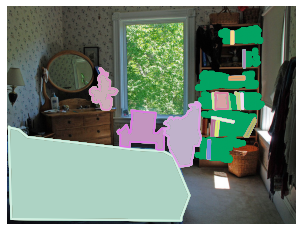

In [164]:
I = Image.open(img_path)
# load and display instance annotations
plt.imshow(I); plt.axis('off')
annIds = val_coco.getAnnIds(imgIds=img_id, iscrowd=None)
anns = val_coco.loadAnns(annIds)
val_coco.showAnns(anns, draw_bbox=False)

In [165]:
# val_coco.showAnns?

In [166]:
# G = nx.relabel.relabel_nodes(G, node_to_cat)
# G = nx.relabel.relabel_nodes(G, label_dict)

In [331]:
model_gcn=GCNNet(2048,80, [32]*2)

In [332]:
nx.set_edge_attributes?

In [334]:
G = val_graphs[idx]
G_nx = utils.convert.to_networkx(val_graphs[idx], to_undirected=True)

node_to_cat = dict(zip(list(G_nx.nodes), list(val_set[idx][2].numpy())))
labels = {key: label_dict[val] for key, val in node_to_cat.items()}
nx.set_node_attributes(G_nx, labels, 'label')

**Drawing Edge Weights**

In [335]:
z=G.x
edge_index=G.edge_index

outputs, attention = model_gcn(z, edge_index, return_attention=True)
# _, predicted = torch.max(outputs, 1)

In [339]:
bb = nx.edge_betweenness_centrality(G_nx, normalized=False)
bb

{(0, 7): 1.0,
 (0, 1): 1.0,
 (0, 8): 15.0,
 (1, 7): 1.0,
 (1, 8): 15.0,
 (2, 9): 1.0,
 (2, 6): 1.5,
 (2, 17): 14.5,
 (3, 16): 3.0,
 (3, 15): 16.5,
 (3, 4): 8.5,
 (4, 16): 6.5,
 (4, 8): 6.0,
 (5, 11): 15.0,
 (5, 6): 7.0,
 (5, 17): 5.0,
 (6, 9): 1.5,
 (6, 17): 9.0,
 (7, 8): 15.0,
 (8, 16): 50.0,
 (9, 17): 14.5,
 (10, 11): 81.0,
 (10, 15): 80.0,
 (11, 17): 65.0,
 (12, 13): 1.0,
 (12, 14): 1.0,
 (12, 17): 15.0,
 (13, 14): 1.0,
 (13, 17): 15.0,
 (14, 17): 15.0,
 (15, 16): 60.5}

In [365]:
%%time
def largest_node_left(row):
    if row[0] < row[1]:
#         print(row[])
        return pd.Series([row[1], row[0], row[2]])
    return row
n_layer=0

n_layer_attention = np.hstack([attention[n_layer][0].detach().cpu().numpy().T.astype(int),attention[n_layer][1].detach().cpu().numpy()])

df_edge_weights = pd.DataFrame(n_layer_attention).apply(lambda x: largest_node_left(x), axis=1).groupby([0,1]).agg({2:np.mean}).reset_index()
edge_weights_dict = dict(zip(tuple(zip(df_edge_weights[0], df_edge_weights[1])), df_edge_weights[2]))



CPU times: user 26.4 ms, sys: 4.05 ms, total: 30.4 ms
Wall time: 27.9 ms


In [366]:
nx.set_edge_attributes(G_nx, edge_weights_dict, 'weight')

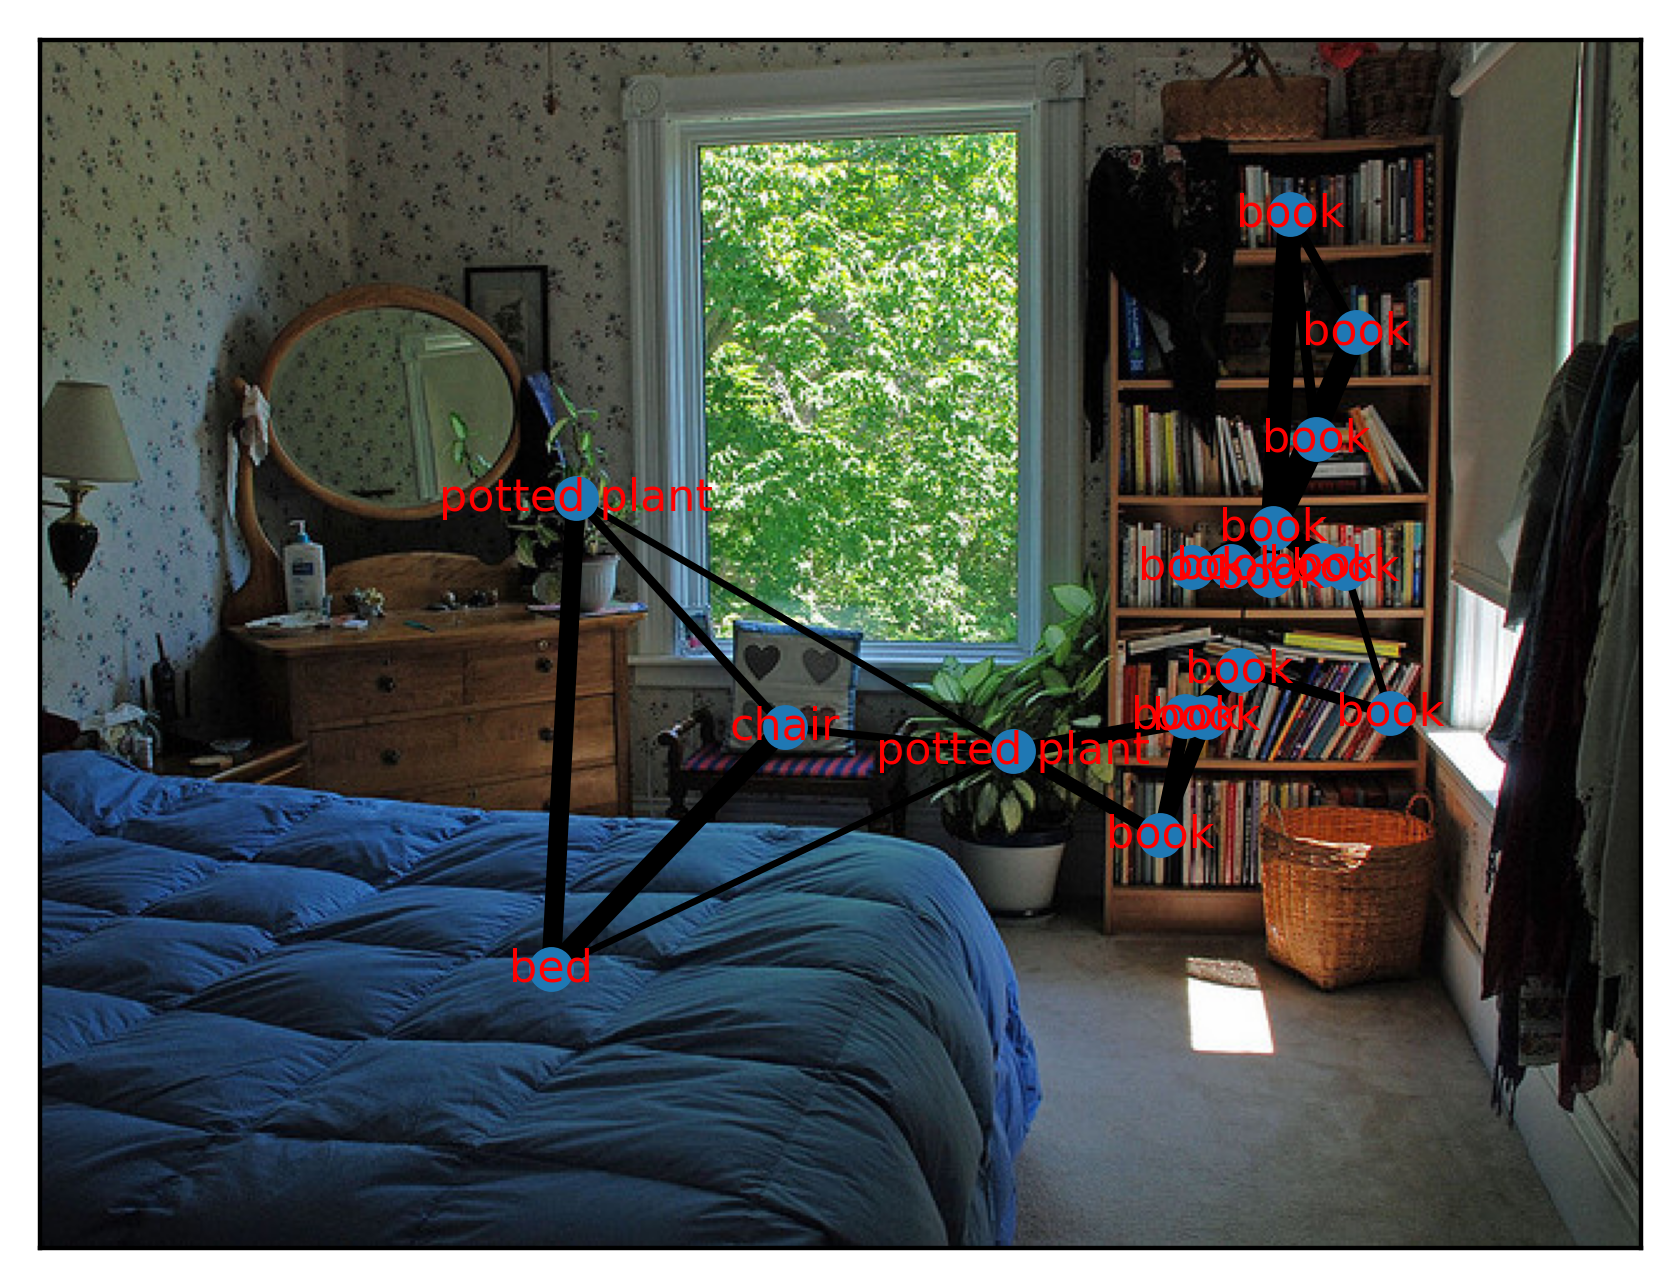

In [368]:
matplotlib.rcParams['figure.dpi']=400

img = Image.open(img_path)
# img = img.resize((128, 128))
nx.draw_networkx_nodes(G_nx, pos, node_size=50)
nx.draw_networkx_edges(G_nx, pos, width=[(G_nx[u][v]['weights'])*10 for u,v in G_nx.edges()])
nx.draw_networkx_labels(G_nx, pos, labels, font_color='red', font_size=8)
plt.imshow(img);

In [256]:
import networkx as nx
import scipy.sparse as sps
from networkx.convert_matrix import to_scipy_sparse_matrix,from_scipy_sparse_matrix



In [325]:
# np.hstack([attention[0][0].detach().cpu().numpy().T.astype(int),attention[0][1].detach().cpu().numpy()])



In [323]:


# np.hstack([attention[1][0].detach().cpu().numpy().T.astype(int),attention[1][1].detach().cpu().numpy()])

CPU times: user 743 µs, sys: 0 ns, total: 743 µs
Wall time: 533 µs


In [310]:
import matplotlib
matplotlib.rcParams['figure.dpi']=400

# G=nx.DiGraph()


# n_layer_attention = np.hstack([attention[n_layer][0].detach().cpu().numpy().T.astype(int),attention[n_layer][1].detach().cpu().numpy()]).tolist()

# G.add_weighted_edges_from(n_layer_attention)

In [329]:
pd.DataFrame(n_layer_attention).apply(lambda x: largest_node_left(x), axis=1).groupby([0,1]).agg({2:np.mean}).reset_index().values.tolist()

In [330]:
# edge_weight_dict = {(u, v): (G[u][v]['weight']) for u,v in G.edges()}
# sort_keys = sorted(edge_weight_dict)
# [{key: edge_weight_dict[key]}for key in sort_keys]

In [362]:
# %%time
# sps_mat=to_scipy_sparse_matrix(G_nx2).toarray()[np.argsort(list(G_nx2.nodes()))].T[np.argsort(list(G_nx2.nodes()))].T
# sps_mat=sps_mat/2.+(sps_mat/2.).T

# G_nx2=from_scipy_sparse_matrix(sps.csr_matrix(sps_mat))

# fig, ax = plt.subplots()

# img = Image.open(img_path)
# # img = img.resize((128, 128))
# nx.draw_networkx_nodes(G_nx2, pos, node_size=50)
# nx.draw_networkx_edges(G_nx2, pos, width=[(G_nx2[u][v]['weight']+1)**5 for u,v in G_nx2.edges()])
# nx.draw_networkx_labels(G_nx2, pos, labels, font_color='red', font_size=8)
# plt.imshow(img);

# # plt.show('x')

NameError: name 'G_nx2' is not defined

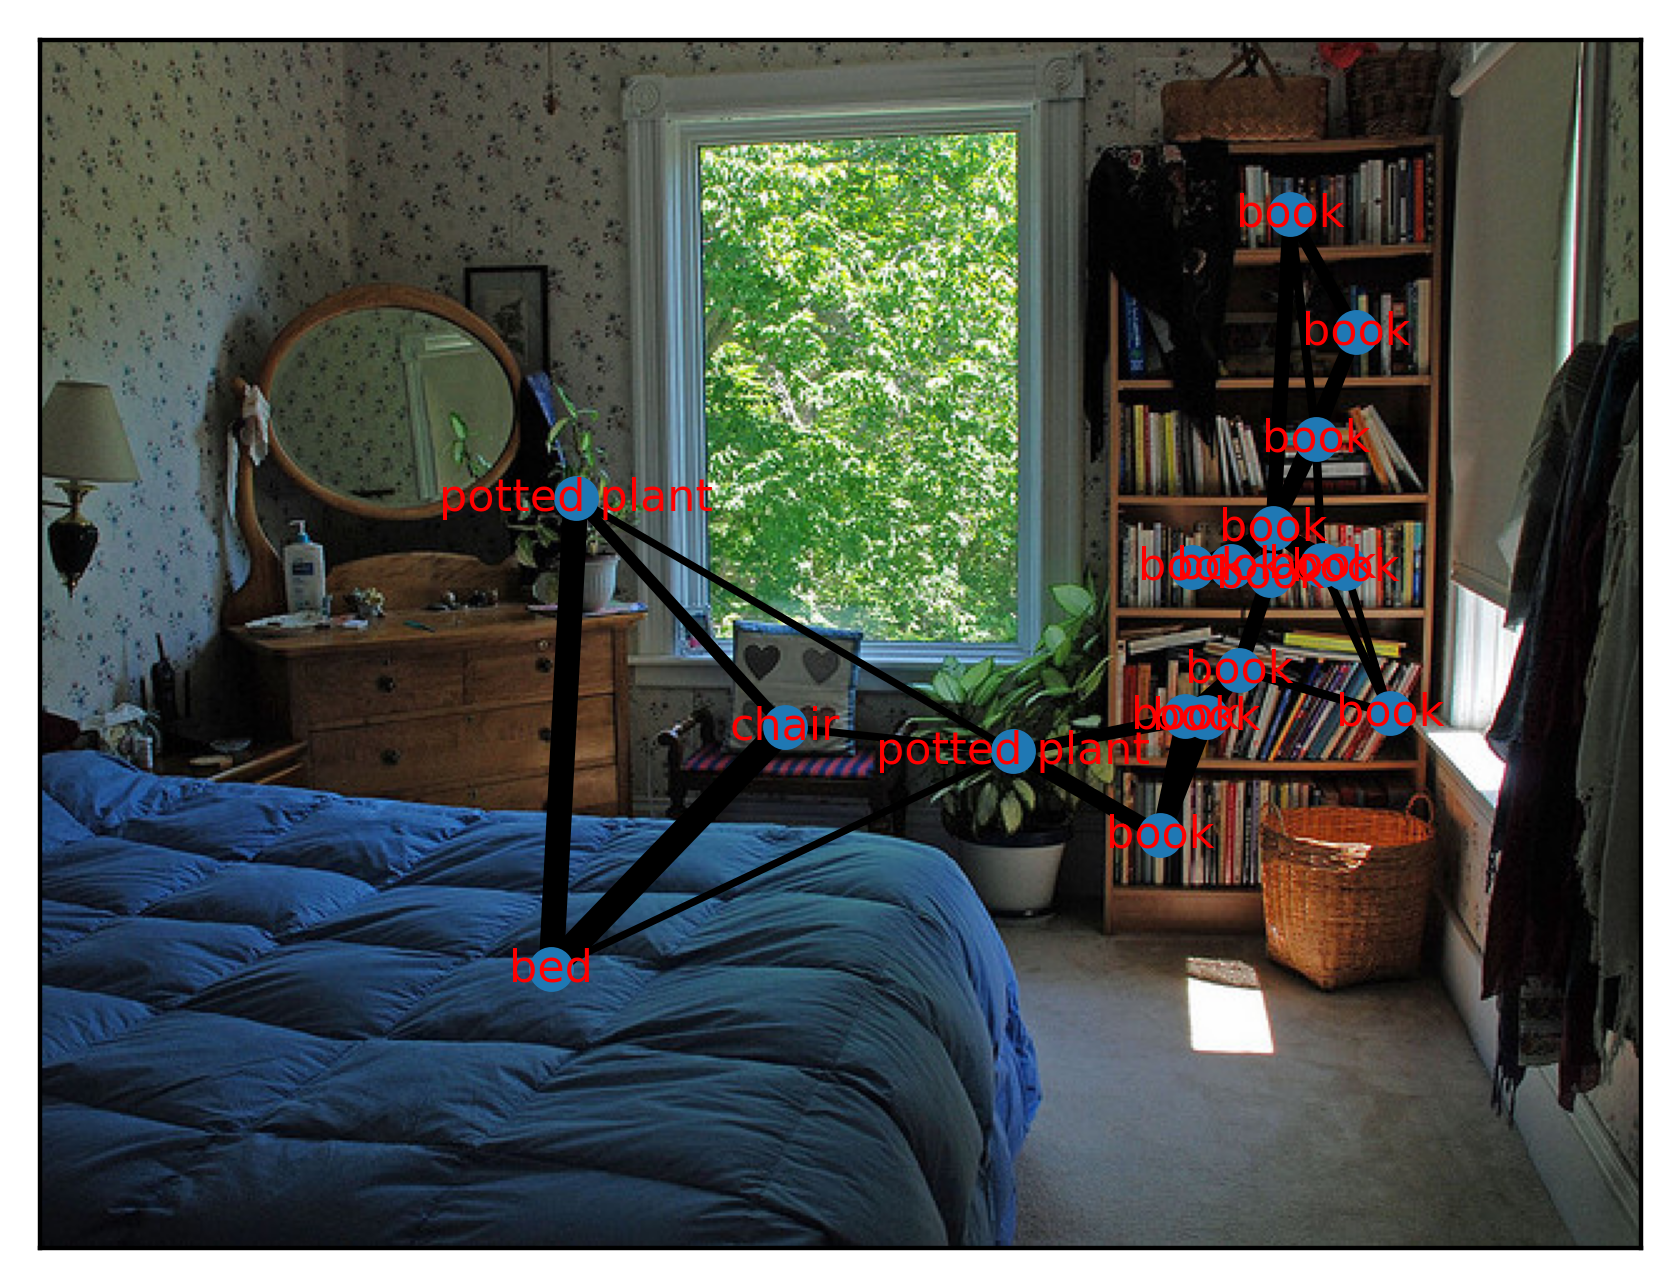

In [364]:
matplotlib.rcParams['figure.dpi']=400

n_layer=0
G_nx2=nx.DiGraph()
G_nx2.add_weighted_edges_from(np.hstack([attention[n_layer][0].detach().cpu().numpy().T.astype(int),attention[n_layer][1].detach().cpu().numpy()]).tolist())
sps_mat=to_scipy_sparse_matrix(G_nx2).toarray()[np.argsort(list(G_nx2.nodes()))].T[np.argsort(list(G_nx2.nodes()))].T
sps_mat=sps_mat/2.+(sps_mat/2.).T
G_nx2=from_scipy_sparse_matrix(sps.csr_matrix(sps_mat))

fig, ax = plt.subplots()

img = Image.open(img_path)
# img = img.resize((128, 128))
nx.draw_networkx_nodes(G_nx2, pos, node_size=50)
nx.draw_networkx_edges(G_nx2, pos, width=[(G_nx2[u][v]['weight']+1)**5 for u,v in G_nx2.edges()])
nx.draw_networkx_labels(G_nx2, pos, labels, font_color='red', font_size=8)
plt.imshow(img);

# plt.show('x')

In [ ]:
i = 0
xmin = anns[i]['bbox'][0]
ymin = anns[i]['bbox'][1]
xmax = xmin + anns[i]['bbox'][2]
ymax = ymin + anns[i]['bbox'][3]
(xmax, xmin, ymax, ymin)

In [100]:
xmin + (xmax - xmin)/2

230.175

In [29]:
img_path

'/datasets/COCO-2017/val2017/000000000724.jpg'

In [55]:
G = utils.convert.to_networkx(val_graphs[3], node_attrs=['x','y','pos'],edge_attrs=['edge_index'], to_undirected=True)

IndexError: list index out of range

In [57]:
import torch

In [60]:
## Params
data = val_graphs[3]
to_undirected = True
edge_attrs = ['edge_index']

In [69]:
val_graphs[7]

Data(edge_index=[2, 12], pos=[4, 2], x=[4, 2048], y=[4])

In [72]:
data.ed

2048

In [63]:

G = nx.Graph()
values = {}
for key, item in data:
    if torch.is_tensor(item):
        values[key] = item.squeeze().tolist()
    else:
        values[key] = item
    if isinstance(values[key], (list, tuple)) and len(values[key]) == 1:
        values[key] = item[0]
print(values)
        
print(data.edge_index.t().tolist())
for i, (u, v) in enumerate(data.edge_index.t().tolist()):
    if to_undirected and v > u:
        continue
    G.add_edge(u, v)
    for key in edge_attrs:
        print(f'i: {i}')
        print(f'graph node/edge: {G[u][v]}')
        
        G[u][v][key] = values[key][i]

{'edge_index': [[1, 3, 2, 3, 2, 0, 3, 1, 0, 1, 2, 0], [0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3]], 'pos': [[67.24500274658203, 76.54000091552734], [10.869999885559082, 15.085000038146973], [6.440000057220459, 4.074999809265137], [9.505000114440918, 13.029999732971191]], 'x': [[0.5216689109802246, 6.475780963897705, 0.009390519931912422, 0.08262418955564499, 0.13708139955997467, 0.0, 0.6570415496826172, 0.06259365379810333, 1.1953063011169434, 0.0536014623939991, 0.3689287602901459, 0.23841792345046997, 0.3332478106021881, 1.0047788619995117, 0.0, 0.14990173280239105, 0.36579665541648865, 0.0, 0.8990810513496399, 0.254824161529541, 0.013011988252401352, 0.021791379898786545, 0.6433477401733398, 0.44969266653060913, 0.17797040939331055, 0.0, 0.042892687022686005, 0.16276201605796814, 0.16402792930603027, 0.18632695078849792, 0.360321044921875, 0.0, 0.0, 0.10031332820653915, 0.07656523585319519, 0.0677473247051239, 0.17121434211730957, 0.04071044921875, 0.05496219918131828, 0.08803436160087585,

IndexError: list index out of range

In [53]:
for key, item in val_graphs[3]:
    print(key)
    print(item)

edge_index
tensor([[1, 3, 2, 3, 2, 0, 3, 1, 0, 1, 2, 0],
        [0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3]])
pos
tensor([[67.2450, 76.5400],
        [10.8700, 15.0850],
        [ 6.4400,  4.0750],
        [ 9.5050, 13.0300]])
x
tensor([[5.2167e-01, 6.4758e+00, 9.3905e-03,  ..., 2.9617e-03, 2.6554e-03,
         5.4697e-01],
        [5.8679e-02, 2.9627e-01, 1.6923e-01,  ..., 3.2275e-02, 1.1050e-02,
         7.1906e-02],
        [3.3200e-01, 6.3743e-01, 4.5312e-03,  ..., 1.7023e-01, 6.7931e-02,
         5.1058e-01],
        [9.6274e-01, 3.4157e+00, 3.0039e-02,  ..., 0.0000e+00, 9.2259e-02,
         5.5440e-01]])
y
tensor([11,  7,  2, 11])


In [35]:
type(G)

networkx.classes.digraph.DiGraph

In [44]:
val_graphs[3].edge_index

tensor([[1, 3, 2, 3, 2, 0, 3, 1, 0, 1, 2, 0],
        [0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3]])

In [42]:
(G.nodes)

NodeView((0, 1, 2, 3))

In [39]:
G.adj

AdjacencyView({0: {1: {}, 2: {}, 3: {}}, 1: {0: {}, 2: {}, 3: {}}, 2: {0: {}, 1: {}, 3: {}}, 3: {0: {}, 1: {}, 2: {}}})

In [24]:
val_graphs[0]

Data(edge_index=[2, 100], pos=[20, 2], x=[20, 2048], y=[20])

TypeError: 'int' object is not subscriptable

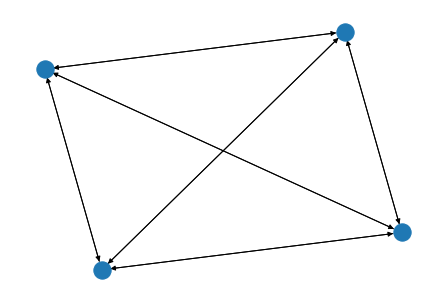

In [23]:
plt.imshow()
nx.draw(utils.convert.to_networkx(val_graphs[3]))
# nx.draw_networkx_labels(utils.convert.to_networkx(val_graphs[3]), )

In [9]:
type(val_graphs[0])

Data(edge_index=[2, 100], pos=[20, 2], x=[20, 2048], y=[20])